# AE352 Final Project - Quadcopter Circling Performance Requirement

Import modules.

In [50]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import importlib
import simulatorCircle
importlib.reload(simulatorCircle)
import sympy as sym
from sympy import Matrix, diag, nsimplify, lambdify
import numpy as np
import scipy.signal
import scipy.linalg

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create and print a seed for the random number generator so it is possible to reproduce the results. Initializes the simulation.

In [51]:
seed = secrets.randbits(32)
print(seed)

1880161787


Create simulator with seed. Appears in most recently used web browser. Uses the simulatorCircle.py file to initialize the environment

In [52]:
simulatorCircle = simulatorCircle.Simulator(
    display=True,
    display_pybullet=False,
    seed=seed,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7031/static/


Mathematical foundation for drone dynamics, explained in report. Produces relevant matrices based on drone parameters that are used by the feedback loop controller. Also provides test methods to ensure functionality such as controlability.

In [53]:
class DroneDynamics:
    def __init__(self):
        """
        Initializes the Drone Dynamics class by defining symbolic variables for drone's position, orientation, 
        velocity, angular velocity, torques, and force. It also sets the drone's physical parameters, initializes 
        matrices, computes equations of motion, and calculates matrices A, B, C, D, K, and L required for control 
        and dynamics analysis.
        """
        # Define symbols
        self.p_x, self.p_y, self.p_z = sym.symbols('p_x, p_y, p_z')
        self.psi, self.theta, self.phi = sym.symbols('psi, theta, phi')
        self.v_x, self.v_y, self.v_z = sym.symbols('v_x, v_y, v_z')
        self.w_x, self.w_y, self.w_z = sym.symbols('w_x, w_y, w_z')
        self.tau_x, self.tau_y, self.tau_z = sym.symbols('tau_x, tau_y, tau_z')
        self.f_z = sym.symbols('f_z')

        # Define parameters
        self.params = {
            'm': 0.57,
            'Jx': 0.0023,
            'Jy': 0.0023,
            'Jz': 0.0040,
            'l': 0.175,
            'g': 9.81,
        }
        self.equilibrium_values = {
            'p_xe': 0, 'p_ye': 0, 'p_ze': 0,
            'psi_e': 0, 'theta_e': 0, 'phi_e': 0,
            'v_xe': 0, 'v_ye': 0, 'v_ze': 0,
            'w_xe': 0, 'w_ye': 0, 'w_ze': 0,
            'tau_xe': 0, 'tau_ye': 0, 'tau_ze': 0,
            'f_ze': 4.905  # 0.5 * 9.81
        }
        self._init_params()

        # Define other matrices and equations
        self._init_matrices()
        self._compute_equations()

        # Calculate A, B, C, D, K, L
        self._calculate_ABCD(self.equilibrium_values)
        self._calculate_KL()

    def _init_params(self):
        self.m = nsimplify(self.params['m'])
        self.Jx = nsimplify(self.params['Jx'])
        self.Jy = nsimplify(self.params['Jy'])
        self.Jz = nsimplify(self.params['Jz'])
        self.l = nsimplify(self.params['l'])
        self.g = nsimplify(self.params['g'])
        self.J = diag(self.Jx, self.Jy, self.Jz)
        self.vxe = 1.0
        self.wye = 0.0
        self.vye = 1.0
        self.wxe = 0.0
        self.phie = 0.0
        self.thetae = 0.0
        self.fze = -(self.vxe * self.wye - self.vye*self.wxe - 981 * np.cos(self.phie) * np.cos(self.thetae) / 100) / 2

    def _init_matrices(self):
        """
        Rotation matrices (Rz, Ry, Rx) for the drone's orientation in 3D space. 
        """
        # rotation matrices
        self.Rz = Matrix([[sym.cos(self.psi), -sym.sin(self.psi), 0], 
                     [sym.sin(self.psi), sym.cos(self.psi), 0], 
                     [0, 0, 1]])
        self.Ry = Matrix([[sym.cos(self.theta), 0, sym.sin(self.theta)], 
                     [0, 1, 0], 
                     [-sym.sin(self.theta), 0, sym.cos(self.theta)]])
        self.Rx = Matrix([[1, 0, 0], 
                     [0, sym.cos(self.phi), -sym.sin(self.phi)], 
                     [0, sym.sin(self.phi), sym.cos(self.phi)]])
        self.R_body_in_world = self.Rz @ self.Ry @ self.Rx

    def _compute_equations(self):
        "Equations of motion computation"
        # components of linear velocity
        v_in_body = Matrix([self.v_x, self.v_y, self.v_z])

        # components of angular velocity
        w_in_body = Matrix([self.w_x, self.w_y, self.w_z])

        # angular velocity to angular rates
        ex = Matrix([[1], [0], [0]])
        ey = Matrix([[0], [1], [0]])
        ez = Matrix([[0], [0], [1]])
        M = sym.simplify(Matrix.hstack((self.Ry @ self.Rx).T @ ez, self.Rx.T @ ey, ex).inv(), full=True)

        # applied forces
        f_in_body = self.R_body_in_world.T @ Matrix([[0], [0], [-self.m * self.g]]) + Matrix([[0], [0], [self.f_z]])

        # applied torques
        tau_in_body = Matrix([[self.tau_x], [self.tau_y], [self.tau_z]])

        # equations of motion
        f = Matrix.vstack(
            self.R_body_in_world @ v_in_body,
            M @ w_in_body,
            (1 / self.m) * (f_in_body - w_in_body.cross(self.m * v_in_body)),
            self.J.inv() @ (tau_in_body - w_in_body.cross(self.J @ w_in_body)),
        )

        self.f = sym.simplify(f, full=True)

        # Sensor model
        p_in_world = Matrix([self.p_x, self.p_y, self.p_z])
        a_in_body = Matrix([self.l, 0, 0])  # marker on front rotor
        b_in_body = Matrix([-self.l, 0, 0]) # marker on rear rotor

        a_in_world = p_in_world + self.R_body_in_world @ a_in_body
        b_in_world = p_in_world + self.R_body_in_world @ b_in_body

        self.g = sym.simplify(Matrix.vstack(a_in_world, b_in_world))

    def _calculate_ABCD(self, equilibrium_values):
        p_xe, p_ye, p_ze, psi_e, theta_e, phi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze = (
            equilibrium_values.get(k, 0) for k in [
                'p_xe', 'p_ye', 'p_ze', 'psi_e', 'theta_e', 'phi_e', 
                'v_xe', 'v_ye', 'v_ze', 'w_xe', 'w_ye', 'w_ze', 
                'tau_xe', 'tau_ye', 'tau_ze', 'f_ze'
            ]
        )

        self.A_num = sym.lambdify((self.p_x, self.p_y, self.p_z,
                            self.psi, self.theta, self.phi,
                            self.v_x, self.v_y, self.v_z,
                            self.w_x, self.w_y, self.w_z,
                            self.tau_x, self.tau_y, self.tau_z, self.f_z), 
                            self.f.jacobian([self.p_x, self.p_y, self.p_z, self.psi, self.theta, 
                                        self.phi, self.v_x, self.v_y, self.v_z, self.w_x, 
                                        self.w_y, self.w_z]))
        latex_matrix = sym.latex(self.f.jacobian([self.p_x, self.p_y, self.p_z, self.psi, self.theta, 
                                        self.phi, self.v_x, self.v_y, self.v_z, self.w_x, 
                                        self.w_y, self.w_z]))
    
        self.B_num =  sym.lambdify((self.p_x, self.p_y, self.p_z,
                            self.psi, self.theta, self.phi,
                            self.v_x, self.v_y, self.v_z,
                            self.w_x, self.w_y, self.w_z,
                            self.tau_x, self.tau_y, self.tau_z, self.f_z), 
                            self.f.jacobian([self.tau_x, self.tau_y, self.tau_z, self.f_z]))
        latex_matrix = sym.latex(self.f.jacobian([self.tau_x, self.tau_y, self.tau_z, self.f_z]))

        self.A = self.A_num(p_xe, p_ye, p_ze, psi_e, theta_e, phi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
        self.B = self.B_num(p_xe, p_ye, p_ze, psi_e, theta_e, phi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)


        # Jacobian
        self.C_num = sym.lambdify((self.p_x, self.p_y, self.p_z, self.psi, self.theta), 
            self.g.jacobian([self.p_x, self.p_y, self.p_z, self.psi, self.theta, self.phi, 
            self.v_x, self.v_y, self.v_z, self.w_x, self.w_y, self.w_z]))
        latex_matrix = sym.latex(self.g.jacobian([self.p_x, self.p_y, self.p_z, self.psi, self.theta, self.phi, 
            self.v_x, self.v_y, self.v_z, self.w_x, self.w_y, self.w_z]))
        self.D_num = sym.lambdify((self.p_x, self.p_y, self.p_z, self.psi, self.theta), 
            self.g.jacobian([self.tau_x, self.tau_y, self.tau_z, self.f_z]))
        latex_matrix = sym.latex(self.g.jacobian([self.tau_x, self.tau_y, self.tau_z, self.f_z]))

        self.C = self.C_num(p_xe, p_ye, p_ze, psi_e, theta_e)
        self.D = self.D_num(p_xe, p_ye, p_ze, psi_e, theta_e)

    def _lqr(self, A, B, Q, R):
        P = scipy.linalg.solve_continuous_are(A, B, Q, R)
        K = np.linalg.inv(R) @ B.T @ P
        return K
    
    def _calculate_KL(self):
        pole = np.linspace(-1, -5, 12)
        K = scipy.signal.place_poles(self.A,self.B, pole).gain_matrix

        Qo = np.identity(self.C.shape[0])
        Ro = np.identity(self.A.shape[0])

        Qinv = np.linalg.inv(Qo)
        Rinv = np.linalg.inv(Ro)

        L = self._lqr(self.A.T, self.C.T, Rinv, Qinv).T

        self.K = K
        self.L = L

    def test_stable_K(self):
        """
        Tests the stability of the feedback gain matrix K. Stability is ensured if the real parts of all 
        eigenvalues of (A - B*K) are negative. This method prints a statement regarding the stability of K.
        """
        eigens_K = np.linalg.eigvals(self.A - self.B @ self.K) 
        if np.all(np.real(eigens_K) < 0):
            print('K matrix is stable')

    def test_stable_L(self):
        """
        Tests the stability of the observer gain matrix L. Stability is ensured if the real parts of all 
        eigenvalues of (A.T - C.T*L.T) are negative. This method prints a statement regarding the stability of L.
        """
        eigens_L = np.linalg.eigvals(self.A.T - self.C.T @ self.L.T)
        if np.all(np.real(eigens_L) < 0):
            print('L matrix is stable')
    def check_controllability(self):
        """
        Checks controllability
        """
        n = self.A.shape[0]  # number of states
        controllability_matrix = self.B
        self.W =controllability_matrix
        for i in range(1, n):
            controllability_matrix = np.hstack((controllability_matrix, np.linalg.matrix_power(self.A, i) @ self.B))

        if np.linalg.matrix_rank(controllability_matrix) == n:
            return True
        else:
            return False
    def check_observability(self):
        """
        Checks observability
        """
        n = self.A.shape[0]  # number of states
        observability_matrix = self.C
        self.O = observability_matrix
        for i in range(1, n):
            observability_matrix = np.vstack((observability_matrix, self.C @ np.linalg.matrix_power(self.A, i)))

        if np.linalg.matrix_rank(observability_matrix) == n:
            return True
        else:
            return False

Test functionality. 

In [54]:
drone = DroneDynamics()
drone.test_stable_K()
drone.test_stable_L()
M=drone.L
# Check controllability
if drone.check_controllability():
    print("The system is controllable.")
else:
    print("The system is not controllable.")

# Check observability
if drone.check_observability():
    print("The system is observable.")
else:
    print("The system is not observable.")

K matrix is stable
L matrix is stable
The system is controllable.
The system is observable.


## Run Simulation 

Generate controller. Needs to be changed dependent on test cases. 

In [55]:
class Controller:
    def __init__(self):
        self.variables_to_log = ['xhat','x_des', 'v_des', 'rpm1', 'rpm2', 'rpm3', 'rpm4']
        self.dt  = .04
        self.A = drone.A
        self.B = drone.B
        self.C = drone.C
        self.D = drone.D
        self.K = drone.K
        self.L = drone.L
        self.fze = drone.fze
        self.base_rpm = 5000 

    def get_color(self):
        "If desired, change these three numbers - RGB values between 0 and 1 - to change the color of your drone."
        return [
            0., # <-- how much red (between 0 and 1)
            0., # <-- how much green (between 0 and 1)
            1., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- drone's approximate initial position
            yaw,           # <-- drone's approximate initial yaw angle
        ):
        self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0]).astype(float)
        self.x_des = np.zeros(12)
    
    def compute_motor_rpms(self, F, tau_x, tau_y, tau_z):
        delta_thrust = F / 4
        delta_pitch = tau_y / 0.02
        delta_roll = tau_x / 0.02
        delta_yaw = tau_z / 0.04

        rpm1 = self.base_rpm + delta_thrust - delta_pitch + delta_roll - delta_yaw
        rpm2 = self.base_rpm + delta_thrust + delta_pitch + delta_roll + delta_yaw
        rpm3 = self.base_rpm + delta_thrust + delta_pitch - delta_roll - delta_yaw
        rpm4 = self.base_rpm + delta_thrust - delta_pitch - delta_roll + delta_yaw

        return rpm1, rpm2, rpm3, rpm4

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,              
            pos_others,                
            time,                      
                                          
                                          
        ):
        x_des = np.zeros(12)
        pos_est = self.xhat[0:3]
        direction_to_target = pos_ring - pos_est
        unit_direction_to_target = direction_to_target / np.linalg.norm(direction_to_target)

        desired_speed = 0.5
       
        v_des = unit_direction_to_target * desired_speed

        e_max = 0.95
        if np.linalg.norm(direction_to_target) > e_max:
            p_des = pos_est + e_max * unit_direction_to_target
        else:
            p_des = pos_ring
        
        x_des[0:3] = p_des
        x_des[6:9] = v_des
        self.x_des = x_des
        self.v_des = v_des

        y = pos_markers
        u = -self.K @ (self.xhat - self.x_des)
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))

        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        f_z = u[3] + self.fze
        # Motor RPM calculation
        self.rpm1, self.rpm2, self.rpm3, self.rpm4 = self.compute_motor_rpms(f_z, tau_x, tau_y, tau_z)

        return tau_x, tau_y, tau_z, f_z

Clear all drones.

In [56]:
simulatorCircle.clear_drones()

Define a controller for the drone.

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'template'` is the name of the drone
* `'Mavic2.png'` is the name of an image to use as a label


In [57]:
simulatorCircle.add_drone(Controller, 'template', 'Mavic2.png')

Adjust camera to track drone.

In [58]:
simulatorCircle.camera_droneview('template')

Reset the drone by setting initial conditions. Is changed depending on test case.

In [59]:
# Reset the simulator
simulatorCircle.reset(
    initial_conditions={
        'template': {
            'p_x': 1.,
            'p_y': 1.,
            'p_z': 0.5,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': 1,
            'p_y_meas': 1,
            'p_z_meas': 0.5,
            'yaw_meas': 0.,

        },
    },
)

Run simulation until `max_time` is reached or if the drone has been disqualified.

In [60]:
simulatorCircle.run(
    max_time=70.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
)

Simulated 1751 time steps in 70.0419 seconds (24.9993 time steps per second)


## Plotting the Results

Assuming,

* Added a drone with the name `template` to the simulator
* Ran the simulation

Get data.

In [61]:
data = simulatorCircle.get_data('template')

Plot trajectory.

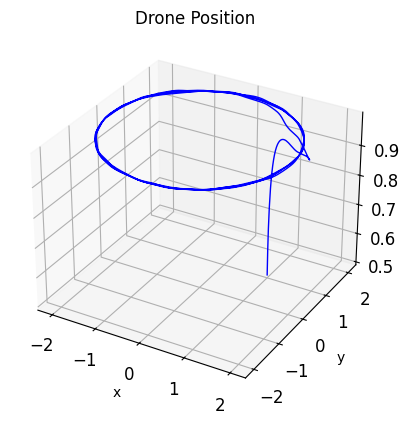

In [62]:
#3-d Drone Position Plot
fig = plt.figure
ax = plt.axes(projection='3d')

ax.plot3D(data['p_x'], data['p_y'], data['p_z'], linewidth=1, color='blue')

ax.set_title('Drone Position')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.grid()
ax.tick_params(labelsize=12)

Plot data.

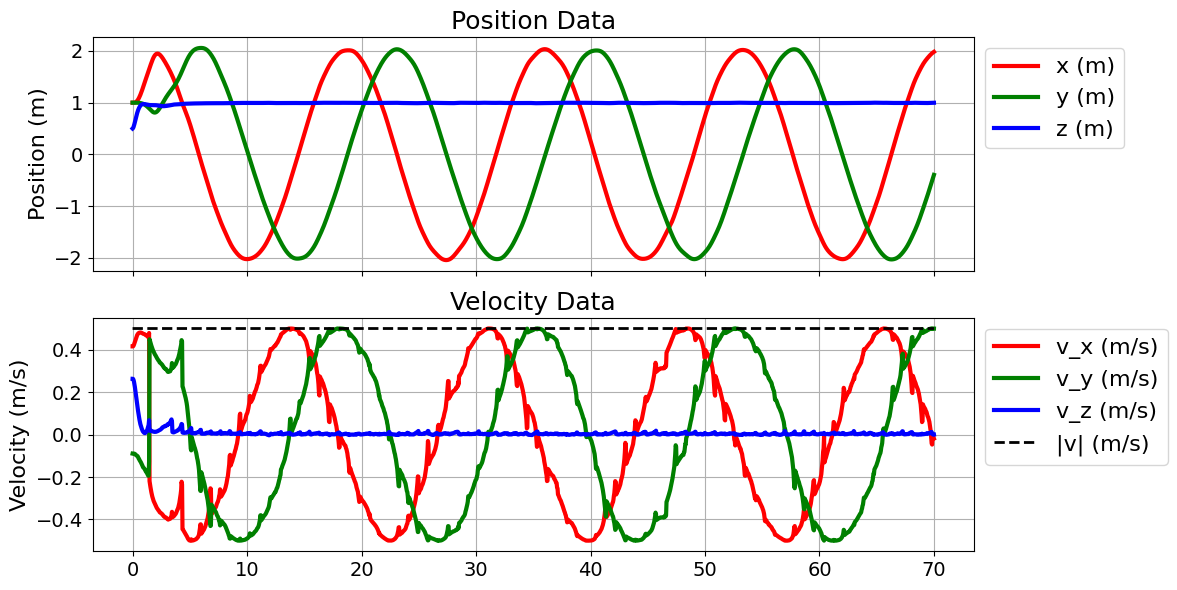

In [63]:
# # Creates set of subplots with same x-axis
fig, (ax_pos, ax_vel) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Position of drone on circular path
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='red')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='green')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='blue')
ax_pos.grid()
ax_pos.legend(loc='upper left', fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)
ax_pos.set_ylabel('Position (m)', fontsize=16)
ax_pos.set_title('Position Data', fontsize=18)

# Velocity of drone on circular path
ax_vel.plot(data['t'], data['v_des'][:, 0], label='v_x (m/s)', color='red', linewidth=3)
ax_vel.plot(data['t'], data['v_des'][:, 1], label='v_y (m/s)', color='green', linewidth=3)
ax_vel.plot(data['t'], data['v_des'][:, 2], label='v_z (m/s)', color='blue', linewidth=3)
velocity_magnitude = np.sqrt(np.sum(data['v_des']**2, axis=1)) # Calculate the magnitude of the velocity vector
ax_vel.plot(data['t'], velocity_magnitude, label='|v| (m/s)', color='black', linewidth=2, linestyle='--') # Plot the magnitude of the velocity
ax_vel.set_ylabel('Velocity (m/s)', fontsize=16)
ax_vel.grid(True)
ax_vel.legend(loc='upper left', fontsize=16, bbox_to_anchor=(1., 1.))
ax_vel.tick_params(labelsize=14)
ax_vel.set_title('Velocity Data', fontsize=18)

# For organization purposes
fig.tight_layout()
plt.show()